# Statystyczna Analiza Danych Chorób Serca

Kompleksowa analiza zbioru danych `heart_cleveland_upload.csv` obejmująca:

1. Wczytanie i wstępne przetwarzanie danych
2. Statystyki opisowe
3. Analiza korelacji
4. **Prosta regresja liniowa z wzorami**
5. Przygotowanie dla modeli ML (XGBoost/Random Forest)
6. Wizualizacja danych


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import os
warnings.filterwarnings('ignore')

output_dir = 'heart_output'
os.makedirs(output_dir, exist_ok=True)

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

polish_labels = {
    'age': 'Wiek',
    'sex': 'Płeć',
    'cp': 'Typ bólu w klatce',
    'trestbps': 'Ciśnienie spoczynkowe',
    'chol': 'Cholesterol',
    'fbs': 'Cukier na czczo >120 mg/dl',
    'restecg': 'EKG spoczynkowe',
    'thalach': 'Maksymalne tętno',
    'exang': 'Ból wysiłkowy',
    'oldpeak': 'Obniżenie ST',
    'slope': 'Nachylenie ST',
    'ca': 'Naczynia barwione',
    'thal': 'Niedokrwistość tarczowatokrwinkowa',
    'condition': 'Choroba serca'
}

def pl(col):
    return polish_labels.get(col, col)

df = pd.read_csv('datasets/heart_cleveland_upload.csv')
print("Dane załadowane pomyślnie!")
print(f"Rozmiar zbioru danych: {df.shape}")
print("\nPierwsze 5 wierszy (oryginalne kolumny):")
df.head()
print("\nMapa etykiet kolumn (ang -> pl):")
for k,v in polish_labels.items():
    print(f"  {k} -> {v}")

Dane załadowane pomyślnie!
Rozmiar zbioru danych: (297, 14)

Pierwsze 5 wierszy (oryginalne kolumny):

Mapa etykiet kolumn (ang -> pl):
  age -> Wiek
  sex -> Płeć
  cp -> Typ bólu w klatce
  trestbps -> Ciśnienie spoczynkowe
  chol -> Cholesterol
  fbs -> Cukier na czczo >120 mg/dl
  restecg -> EKG spoczynkowe
  thalach -> Maksymalne tętno
  exang -> Ból wysiłkowy
  oldpeak -> Obniżenie ST
  slope -> Nachylenie ST
  ca -> Naczynia barwione
  thal -> Niedokrwistość tarczowatokrwinkowa
  condition -> Choroba serca


## 1. Import bibliotek i wczytanie danych


## 2. Przetwarzanie wstępne - czyszczenie i obsługa brakujących danych


In [17]:
def clean_and_handle_missing_data(df):
    print("=== ANALIZA JAKOŚCI DANYCH ===\n")

    print("1. Informacje ogólne:")
    print(f"   - Wiersze: {df.shape[0]}")
    print(f"   - Kolumny: {df.shape[1]}")
    print(f"   - Typy danych:\n{df.dtypes}")

    print("\n2. Analiza brakujących wartości:")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Kolumna (ang)': missing_values.index,
        'Kolumna (pl)': [pl(c) for c in missing_values.index],
        'Brakujące wartości': missing_values.values,
        'Procent': missing_percentage.values
    })
    polish_missing = missing_df[missing_df['Brakujące wartości'] > 0]
    print(polish_missing if not polish_missing.empty else "   Nie znaleziono brakujących wartości!")

    print("\n3. Analiza duplikatów:")
    duplicates = df.duplicated().sum()
    print(f"   Liczba duplikatów: {duplicates}")

    print("\n4. Analiza zakresów wartości i wartości odstających:")
    df_clean = df.copy()

    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

        print(f"   {pl(column)} ({column}):")
        print(f"      Zakres: [{df[column].min():.3f}, {df[column].max():.3f}]")
        print(f"      Wartości odstające: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"\n5. Usunięto {duplicates} duplikatów")

    def fill_missing_values(df_local, method='mean'):
        df_filled = df_local.copy()
        for column in df_local.columns:
            if df_local[column].isnull().sum() > 0:
                if method == 'mean':
                    df_filled[column].fillna(df_local[column].mean(), inplace=True)
                elif method == 'median':
                    df_filled[column].fillna(df_local[column].median(), inplace=True)
        return df_filled

    if missing_values.sum() > 0:
        df_clean = fill_missing_values(df_clean, method='mean')
        print("6. Wypełniono brakujące wartości średnimi")

    print(f"\n=== DANE PO CZYSZCZENIU ===")
    print(f"Rozmiar: {df_clean.shape}")
    print("Czyszczenie danych zakończone pomyślnie!")

    return df_clean

df_clean = clean_and_handle_missing_data(df)

=== ANALIZA JAKOŚCI DANYCH ===

1. Informacje ogólne:
   - Wiersze: 297
   - Kolumny: 14
   - Typy danych:
age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

2. Analiza brakujących wartości:
   Nie znaleziono brakujących wartości!

3. Analiza duplikatów:
   Liczba duplikatów: 0

4. Analiza zakresów wartości i wartości odstających:
   Wiek (age):
      Zakres: [29.000, 77.000]
      Wartości odstające: 0 (0.00%)
   Płeć (sex):
      Zakres: [0.000, 1.000]
      Wartości odstające: 0 (0.00%)
   Typ bólu w klatce (cp):
      Zakres: [0.000, 3.000]
      Wartości odstające: 23 (7.74%)
   Ciśnienie spoczynkowe (trestbps):
      Zakres: [94.000, 200.000]
      Wartości odstające: 9 (3.03%)
   Cholesterol (chol):
      Zakres: [126.000, 56

## 3. Statystyki opisowe


In [18]:
def calculate_descriptive_statistics(df):
    print("=== STATYSTYKI OPISOWE ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    stats_dict = {}

    for column in numeric_columns:
        data = df[column]
        stats_dict[column] = {
            'Min': data.min(),
            'Max': data.max(),
            'Zakres': data.max() - data.min(),
            'Średnia': data.mean(),
            'Odch. std': data.std(),
            'Mediana': data.median(),
            'Q1 (25%)': data.quantile(0.25),
            'Q3 (75%)': data.quantile(0.75),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Kwantyl 0.1': data.quantile(0.1),
            'Kwantyl 0.9': data.quantile(0.9),
            'Skośność': data.skew(),
            'Kurtoza': data.kurtosis()
        }

    stats_df = pd.DataFrame(stats_dict).T

    polish_index = [pl(c) for c in stats_df.index]
    stats_df_print = stats_df.copy()
    stats_df_print.index = polish_index

    print("Podstawowe statystyki opisowe (etykiety PL):")
    print("="*80)
    main_stats = stats_df_print[['Min', 'Max', 'Zakres', 'Średnia', 'Odch. std', 'Mediana']]
    print(main_stats.round(3))

    print("\n" + "="*80)
    print("Kwartyle i kwantyle (etykiety PL):")
    print("="*80)
    quartile_stats = stats_df_print[['Q1 (25%)', 'Mediana', 'Q3 (75%)', 'IQR', 'Kwantyl 0.1', 'Kwantyl 0.9']]
    print(quartile_stats.round(3))

    print("\n" + "="*80)
    print("Miary kształtu rozkładu (etykiety PL):")
    print("="*80)
    shape_stats = stats_df_print[['Skośność', 'Kurtoza']]
    print(shape_stats.round(3))

    print("\nInterpretacja kształtu:")
    for column in numeric_columns:
        skewness = stats_df.loc[column, 'Skośność']
        kurtosis = stats_df.loc[column, 'Kurtoza']

        if abs(skewness) < 0.5:
            skew_desc = "symetryczny"
        elif skewness > 0.5:
            skew_desc = "prawostronnie skośny (ogon po prawej)"
        else:
            skew_desc = "lewostronnie skośny (ogon po lewej)"

        if abs(kurtosis) < 0.5:
            kurt_desc = "mezokurtyczny (normalny)"
        elif kurtosis > 0.5:
            kurt_desc = "leptokurtyczny (ostry szczyt)"
        else:
            kurt_desc = "platykurtyczny (płaski szczyt)"

        print(f"  {pl(column)} ({column}): {skew_desc}, {kurt_desc}")

    stats_df.to_csv(f"{output_dir}/descriptive_statistics.csv", index=True)
    stats_df_print.to_csv(f"{output_dir}/descriptive_statistics_pl.csv", index=True)
    print(f"\n✓ Zapisano: {output_dir}/descriptive_statistics.csv (ang) oraz descriptive_statistics_pl.csv (pl)")

    return stats_df

descriptive_stats = calculate_descriptive_statistics(df_clean)

=== STATYSTYKI OPISOWE ===

Podstawowe statystyki opisowe (etykiety PL):
                                      Min    Max  Zakres  Średnia  Odch. std  \
Wiek                                 29.0   77.0    48.0   54.542      9.050   
Płeć                                  0.0    1.0     1.0    0.677      0.468   
Typ bólu w klatce                     0.0    3.0     3.0    2.158      0.965   
Ciśnienie spoczynkowe                94.0  200.0   106.0  131.694     17.763   
Cholesterol                         126.0  564.0   438.0  247.350     51.998   
Cukier na czczo >120 mg/dl            0.0    1.0     1.0    0.145      0.352   
EKG spoczynkowe                       0.0    2.0     2.0    0.997      0.995   
Maksymalne tętno                     71.0  202.0   131.0  149.599     22.942   
Ból wysiłkowy                         0.0    1.0     1.0    0.327      0.470   
Obniżenie ST                          0.0    6.2     6.2    1.056      1.166   
Nachylenie ST                         0.0    2.

## 4. Analiza korelacji liniowej Pearsona


In [19]:
def analyze_correlations(df):
    print("=== ANALIZA KORELACJI LINIOWEJ PEARSONA ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    correlation_matrix = df[numeric_columns].corr(method='pearson')

    print("1. Macierz korelacji Pearsona (etykiety PL):")
    print("="*50)
    correlation_matrix_polish = correlation_matrix.rename(index=pl, columns=pl)
    print(correlation_matrix_polish.round(3))

    print("\n2. Silne korelacje (|r| > 0.5):")
    print("="*50)

    strong_correlations = []
    for i, col1 in enumerate(numeric_columns):
        for j, col2 in enumerate(numeric_columns):
            if i < j:
                corr_coef = correlation_matrix.loc[col1, col2]
                if abs(corr_coef) > 0.5:
                    _, p_value = pearsonr(df[col1], df[col2])
                    strong_correlations.append({
                        'Zmienna 1 (ang)': col1,
                        'Zmienna 1 (pl)': pl(col1),
                        'Zmienna 2 (ang)': col2,
                        'Zmienna 2 (pl)': pl(col2),
                        'Korelacja': corr_coef,
                        'p-wartość': p_value,
                        'Istotna (p<0.05)': 'Tak' if p_value < 0.05 else 'Nie'
                    })

    if strong_correlations:
        strong_corr_df = pd.DataFrame(strong_correlations)
        strong_corr_df = strong_corr_df.sort_values('Korelacja', key=abs, ascending=False)
        print(strong_corr_df)
    else:
        strong_corr_df = None
        print("Brak korelacji z |r| > 0.5")

    print("\n3. Korelacje ze zmienną Choroba serca (condition):")
    print("="*50)

    if 'condition' in numeric_columns:
        quality_correlations = []
        for column in numeric_columns:
            if column != 'condition':
                corr_coef, p_value = pearsonr(df[column], df['condition'])
                quality_correlations.append({
                    'Zmienna (ang)': column,
                    'Zmienna (pl)': pl(column),
                    'Korelacja z Choroba serca (condition)': corr_coef,
                    'p-wartość': p_value,
                    'Istotna (p<0.05)': 'Tak' if p_value < 0.05 else 'Nie'
                })

        quality_corr_df = pd.DataFrame(quality_correlations)
        quality_corr_df = quality_corr_df.sort_values('Korelacja z Choroba serca (condition)', key=abs, ascending=False)
        print(quality_corr_df.round(4))
    else:
        quality_corr_df = None

    print("\n4. Interpretacja siły korelacji:")
    print("="*40)
    print("0.0 - 0.2: bardzo słaba")
    print("0.2 - 0.4: słaba")
    print("0.4 - 0.6: umiarkowana")
    print("0.6 - 0.8: silna")
    print("0.8 - 1.0: bardzo silna")

    return correlation_matrix, strong_corr_df, quality_corr_df

correlation_matrix, strong_correlations_df, condition_correlations_df = analyze_correlations(df_clean)

=== ANALIZA KORELACJI LINIOWEJ PEARSONA ===

1. Macierz korelacji Pearsona (etykiety PL):
                                     Wiek   Płeć  Typ bólu w klatce  \
Wiek                                1.000 -0.092              0.110   
Płeć                               -0.092  1.000              0.009   
Typ bólu w klatce                   0.110  0.009              1.000   
Ciśnienie spoczynkowe               0.290 -0.066             -0.037   
Cholesterol                         0.203 -0.198              0.072   
Cukier na czczo >120 mg/dl          0.132  0.039             -0.058   
EKG spoczynkowe                     0.150  0.034              0.064   
Maksymalne tętno                   -0.395 -0.060             -0.339   
Ból wysiłkowy                       0.096  0.144              0.378   
Obniżenie ST                        0.197  0.107              0.203   
Nachylenie ST                       0.159  0.033              0.151   
Naczynia barwione                   0.362  0.092          

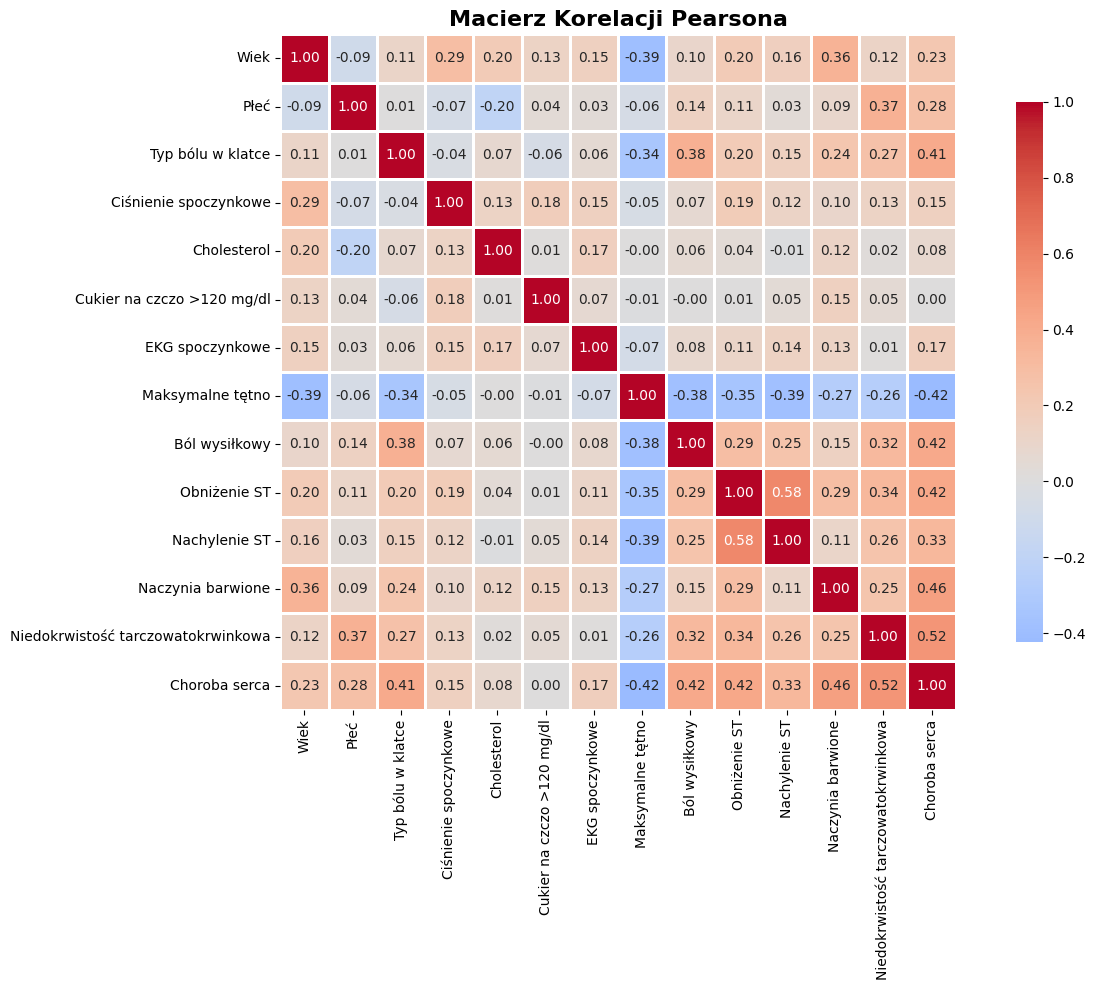

✓ Wykres zapisany: heart_output/correlation_heatmap.png


In [20]:
plt.figure(figsize=(14, 10))
polish_cols = [pl(c) for c in correlation_matrix.columns]
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            xticklabels=polish_cols, yticklabels=polish_cols)
plt.title('Macierz Korelacji Pearsona', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/correlation_heatmap.png")

## 5. Prosta regresja liniowa


In [21]:
def perform_linear_regression_analysis(df):
    print("=== PROSTA REGRESJA LINIOWA ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    print("1. Regresja liniowa: predykcja Choroba serca (condition) (sklearn)")
    print("="*60)

    correlations_with_condition = []
    for col in numeric_columns:
        if col != 'condition' and 'condition' in df.columns:
            corr = df[col].corr(df['condition'])
            correlations_with_condition.append((col, abs(corr), corr))

    if not correlations_with_condition:
        print("Brak zmiennej condition - używam przykładowych par zmiennych")
        regression_pairs = [('age', 'trestbps'), ('age', 'chol'), ('trestbps', 'chol')]

        for x_col, y_col in regression_pairs[:3]:
            print(f"\n{pl(x_col)} ({x_col}) → {pl(y_col)} ({y_col}):")
            print("-" * 40)

            X = df[[x_col]]
            y = df[y_col]

            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = r2_score(y, y_pred)

            print(f"   Wzór regresji liniowej:")
            print(f"   {pl(y_col)} ({y_col}) = {intercept:.4f} + {slope:.4f} × {pl(x_col)} ({x_col})")
            print(f"   R² = {r_squared:.4f}")
        return [], None, x_col

    correlations_with_condition.sort(key=lambda x: x[1], reverse=True)
    top_predictors = correlations_with_condition[:3]

    for i, (predictor, _, corr) in enumerate(top_predictors, 1):
        print(f"\n{i}. {pl(predictor)} ({predictor}) → Choroba serca (condition) (r = {corr:.3f}):")
        print("-" * 60)

        X = df[[predictor]]
        y = df['condition']

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        print(f"   Wzór regresji liniowej:")
        print(f"   Choroba serca (condition) = {intercept:.4f} + {slope:.4f} × {pl(predictor)} ({predictor})")
        print(f"   Parametry (sklearn):")
        print(f"   • Współczynnik kierunkowy (slope) a = {slope:.4f}")
        print(f"   • Wyraz wolny (intercept) b = {intercept:.4f}")
        print(f"   • Współczynnik korelacji r = {corr:.4f}")
        print(f"   • Współczynnik determinacji R² = {r_squared:.4f} ({r_squared*100:.1f}% wyjaśnionej wariancji)")
        print(f"   • Błąd średniokwadratowy (MSE) = {mse:.4f}")
        print(f"   • RMSE = {rmse:.4f}")
        print(f"   ✓ Model score: {model.score(X, y):.4f}")

        if corr > 0:
            print(f"   ✓ Zależność dodatnia: wzrost {pl(predictor)} ({predictor}) o 1 jednostkę → wzrost Choroba serca (condition) o {slope:.4f}")
        else:
            print(f"   ✓ Zależność ujemna: wzrost {pl(predictor)} ({predictor}) o 1 jednostkę → spadek Choroba serca (condition) o {abs(slope):.4f}")

    print(f"\n" + "="*60)
    print("2. Regresja wielokrotna (multiple regression) - top 3 predyktory:")
    print("="*60)

    top_3_vars = [x[0] for x in top_predictors]
    X_multi = df[top_3_vars]
    y = df['condition']

    model_multi = LinearRegression()
    model_multi.fit(X_multi, y)
    y_pred_multi = model_multi.predict(X_multi)
    r_squared_multi = r2_score(y, y_pred_multi)
    mse_multi = mean_squared_error(y, y_pred_multi)
    rmse_multi = np.sqrt(mse_multi)

    print("Regresja wielokrotna dla top 3 predyktorów:")
    formula = f"Choroba serca (condition) = {model_multi.intercept_:.4f}"
    for var, coef in zip(top_3_vars, model_multi.coef_):
        formula += f" + {coef:.4f}×{pl(var)} ({var})"
    print(formula)

    print(f"R² = {r_squared_multi:.4f} ({r_squared_multi*100:.2f}% wyjaśnionej wariancji)")
    print(f"MSE = {mse_multi:.4f}, RMSE = {rmse_multi:.4f}")

    print(f"\n3. Przygotowanie danych dla zaawansowanych modeli ML:")
    print("="*60)
    print("   ✓ Regresja liniowa wykonana (sklearn) - podstawa do porównania")
    print("   ✓ Dane przygotowane do modeli XGBoost/Random Forest")
    print(f"   ✓ Najlepszy predyktor liniowy: {pl(top_predictors[0][0])} ({top_predictors[0][0]})")

    return correlations_with_condition, model_multi, top_predictors[0][0]

feature_ranking, multi_model, best_predictor = perform_linear_regression_analysis(df_clean)

=== PROSTA REGRESJA LINIOWA ===

1. Regresja liniowa: predykcja Choroba serca (condition) (sklearn)

1. Niedokrwistość tarczowatokrwinkowa (thal) → Choroba serca (condition) (r = 0.521):
------------------------------------------------------------
   Wzór regresji liniowej:
   Choroba serca (condition) = 0.2344 + 0.2717 × Niedokrwistość tarczowatokrwinkowa (thal)
   Parametry (sklearn):
   • Współczynnik kierunkowy (slope) a = 0.2717
   • Wyraz wolny (intercept) b = 0.2344
   • Współczynnik korelacji r = 0.5205
   • Współczynnik determinacji R² = 0.2709 (27.1% wyjaśnionej wariancji)
   • Błąd średniokwadratowy (MSE) = 0.1812
   • RMSE = 0.4256
   ✓ Model score: 0.2709
   ✓ Zależność dodatnia: wzrost Niedokrwistość tarczowatokrwinkowa (thal) o 1 jednostkę → wzrost Choroba serca (condition) o 0.2717

2. Naczynia barwione (ca) → Choroba serca (condition) (r = 0.463):
------------------------------------------------------------
   Wzór regresji liniowej:
   Choroba serca (condition) = 0.29

## 6. Przygotowanie dla zaawansowanych modeli ML


In [22]:
def prepare_for_ml_models(df):
    print("=== PRZYGOTOWANIE DANYCH DLA ZAAWANSOWANYCH MODELI ML ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    print("1. Ranking cech dla modeli ML (etykiety PL):")
    print("="*50)

    if 'condition' in df.columns:
        correlations_with_target = []
        for col in numeric_columns:
            if col != 'condition':
                corr = df[col].corr(df['condition'])
                correlations_with_target.append((col, abs(corr), corr))

        correlations_with_target.sort(key=lambda x: x[1], reverse=True)

        print("Ranking zmiennych według siły korelacji z Choroba serca (condition):")
        for i, (predictor, abs_corr, corr) in enumerate(correlations_with_target, 1):
            direction = "dodatnia" if corr > 0 else "ujemna"
            strength = "bardzo silna" if abs_corr > 0.7 else "silna" if abs_corr > 0.5 else "umiarkowana" if abs_corr > 0.3 else "słaba"
            print(f"   {i:2d}. {pl(predictor):25s} ({predictor:>10s}): r = {corr:6.3f} ({direction:8s}, {strength})")

        print(f"\n2. Charakterystyka zbioru danych:")
        print("="*50)
        print(f"   • Liczba próbek: {len(df)}")
        print(f"   • Liczba cech (predyktory): {len(numeric_columns)-1}")
        print(f"   • Zmienna docelowa: Choroba serca (condition) (zakres: {df['condition'].min()}-{df['condition'].max()})")

        print(f"\n   • Rozkład klas Choroba serca (condition):")
        condition_counts = df['condition'].value_counts().sort_index()
        for condition, count in condition_counts.items():
            percentage = (count / len(df)) * 100
            print(f"     Klasa {condition}: {count:4d} próbek ({percentage:5.1f}%)")

        top_3_predictors = [x[0] for x in correlations_with_target[:3]]
    else:
        correlations_with_target = []
        top_3_predictors = list(numeric_columns[:3])
        print("   Brak zmiennej condition - analiza ogólna")

    print(f"\n3. Analiza multikolinearności:")
    print("="*50)

    predictor_columns = [col for col in numeric_columns if col != 'condition']
    high_correlations = []

    for i, col1 in enumerate(predictor_columns):
        for j, col2 in enumerate(predictor_columns):
            if i < j:
                corr = df[col1].corr(df[col2])
                if abs(corr) > 0.7:
                    high_correlations.append((col1, col2, corr))

    if high_correlations:
        print("   Silnie skorelowane pary zmiennych (|r| > 0.7):")
        for col1, col2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
            print(f"     {pl(col1)} ({col1}) ↔ {pl(col2)} ({col2}): r = {corr:.3f}")
        print("   UWAGA: Rozważ usunięcie jednej ze zmiennych z każdej pary")
    else:
        print("   Brak silnych korelacji między predyktorami (|r| > 0.7)")

    print(f"\n4. Rekomendacje dla modeli ML:")
    print("="*50)
    print("   ✓ Dane są gotowe do modelowania ML")
    print("   ✓ Brak brakujących wartości")
    print(f"   ✓ Top 3 predyktory: {', '.join(f'{pl(x)} ({x})' for x in top_3_predictors)}")
    print("   ✓ Random Forest: może obsłużyć wszystkie cechy")
    print("   ✓ XGBoost: może obsłużyć wszystkie cechy")

    if len(high_correlations) > 0:
        print("   ⚠ Uwaga: wykryto multikolinearność - może wpłynąć na interpretację")

    print(f"\n   Gotowy zbiór danych dla treningu modeli:")
    print(f"   • X (cechy): {len(predictor_columns)} zmiennych")
    print(f"   • y (cel): Choroba serca (condition)")
    print(f"   • Rekomendowany podział: 80% trening, 20% test")

    return correlations_with_target, top_3_predictors

ml_features, top_features = prepare_for_ml_models(df_clean)

=== PRZYGOTOWANIE DANYCH DLA ZAAWANSOWANYCH MODELI ML ===

1. Ranking cech dla modeli ML (etykiety PL):
Ranking zmiennych według siły korelacji z Choroba serca (condition):
    1. Niedokrwistość tarczowatokrwinkowa (      thal): r =  0.521 (dodatnia, silna)
    2. Naczynia barwione         (        ca): r =  0.463 (dodatnia, umiarkowana)
    3. Obniżenie ST              (   oldpeak): r =  0.424 (dodatnia, umiarkowana)
    4. Maksymalne tętno          (   thalach): r = -0.424 (ujemna  , umiarkowana)
    5. Ból wysiłkowy             (     exang): r =  0.421 (dodatnia, umiarkowana)
    6. Typ bólu w klatce         (        cp): r =  0.409 (dodatnia, umiarkowana)
    7. Nachylenie ST             (     slope): r =  0.333 (dodatnia, umiarkowana)
    8. Płeć                      (       sex): r =  0.278 (dodatnia, słaba)
    9. Wiek                      (       age): r =  0.227 (dodatnia, słaba)
   10. EKG spoczynkowe           (   restecg): r =  0.166 (dodatnia, słaba)
   11. Ciśnienie spocz

## 7. Wizualizacja danych

### 7.1 Wykresy kołowe - rozkład zmiennych kategorycznych


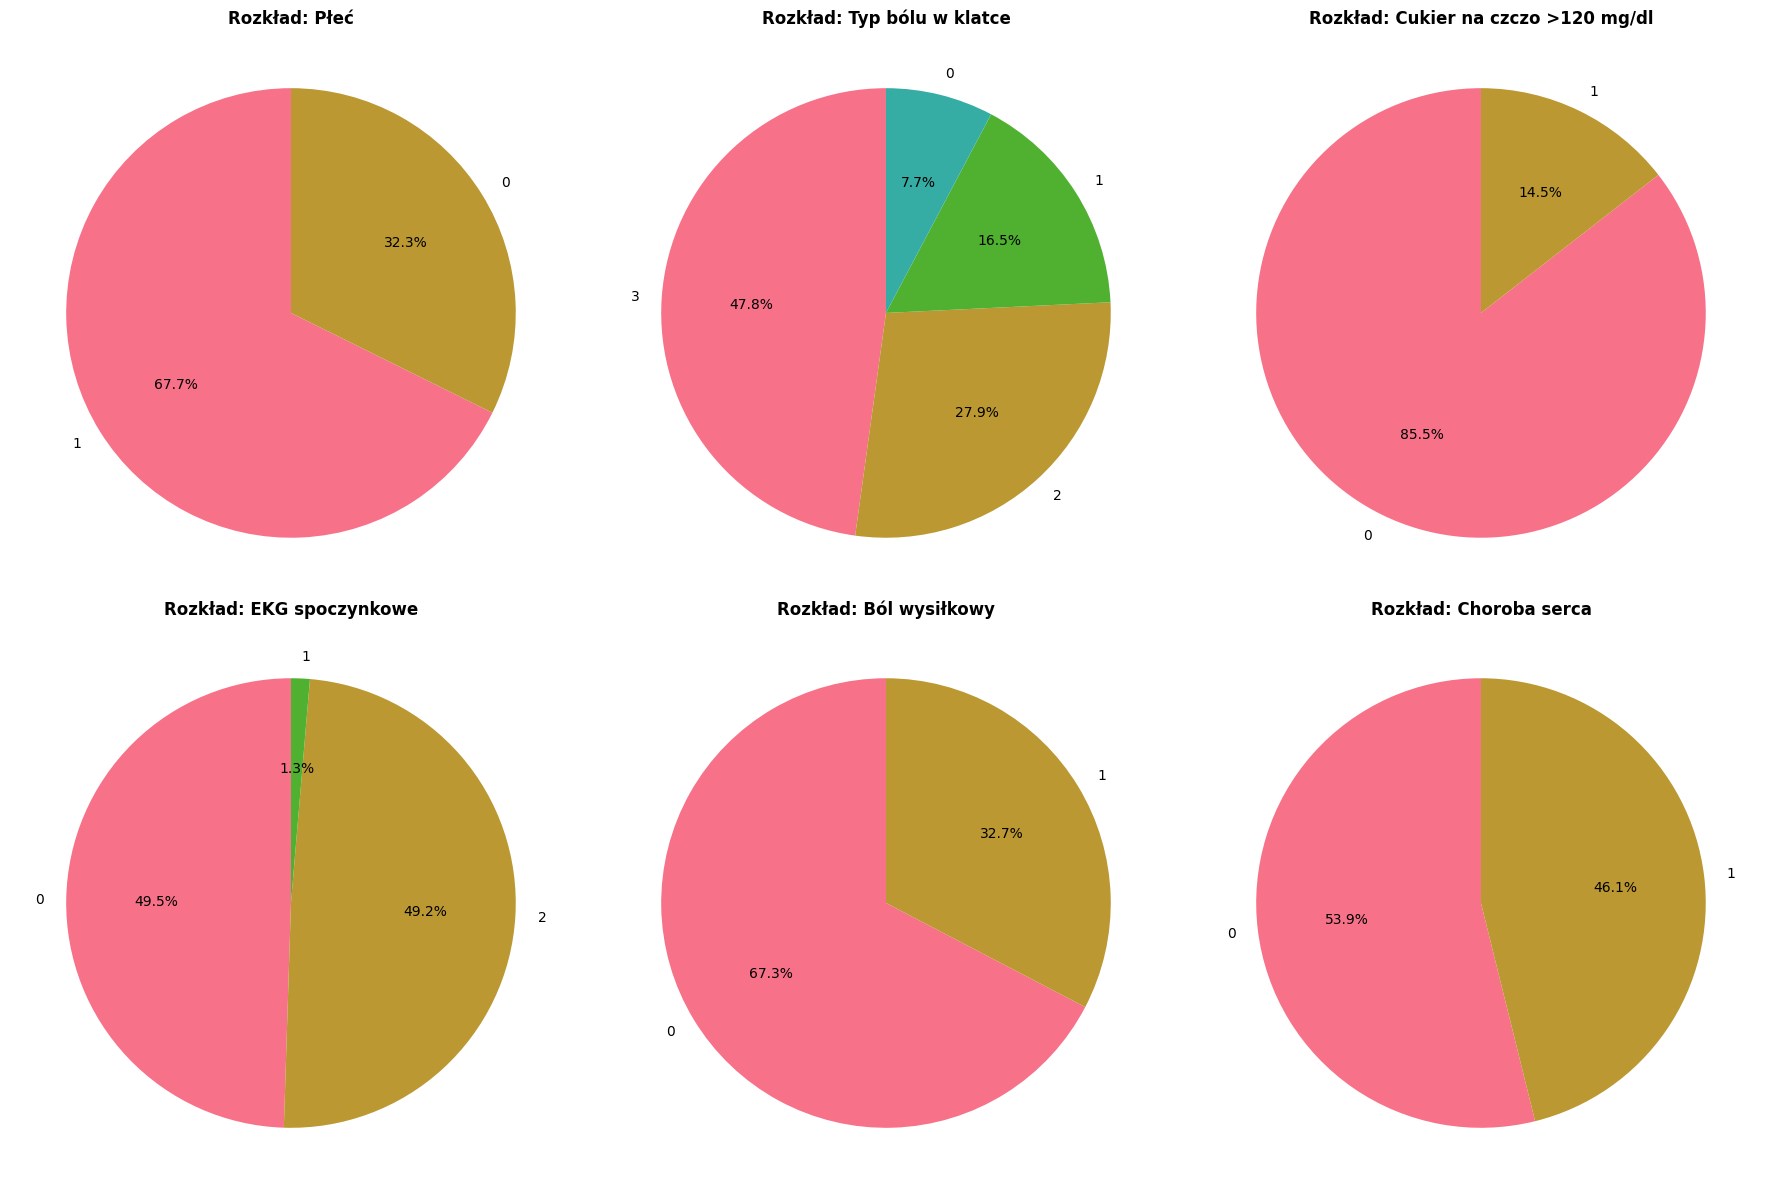

✓ Wykres zapisany: heart_output/pie_charts.png


In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'condition']
for idx, col in enumerate(categorical_cols):
    if col in df_clean.columns and idx < len(axes):
        ax = axes[idx]
        value_counts = df_clean[col].value_counts()
        ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'Rozkład: {pl(col)}', fontweight='bold')

for idx in range(len([c for c in categorical_cols if c in df_clean.columns]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/pie_charts.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/pie_charts.png")

### 7.2 Wykresy słupkowe - liczebność w klasach


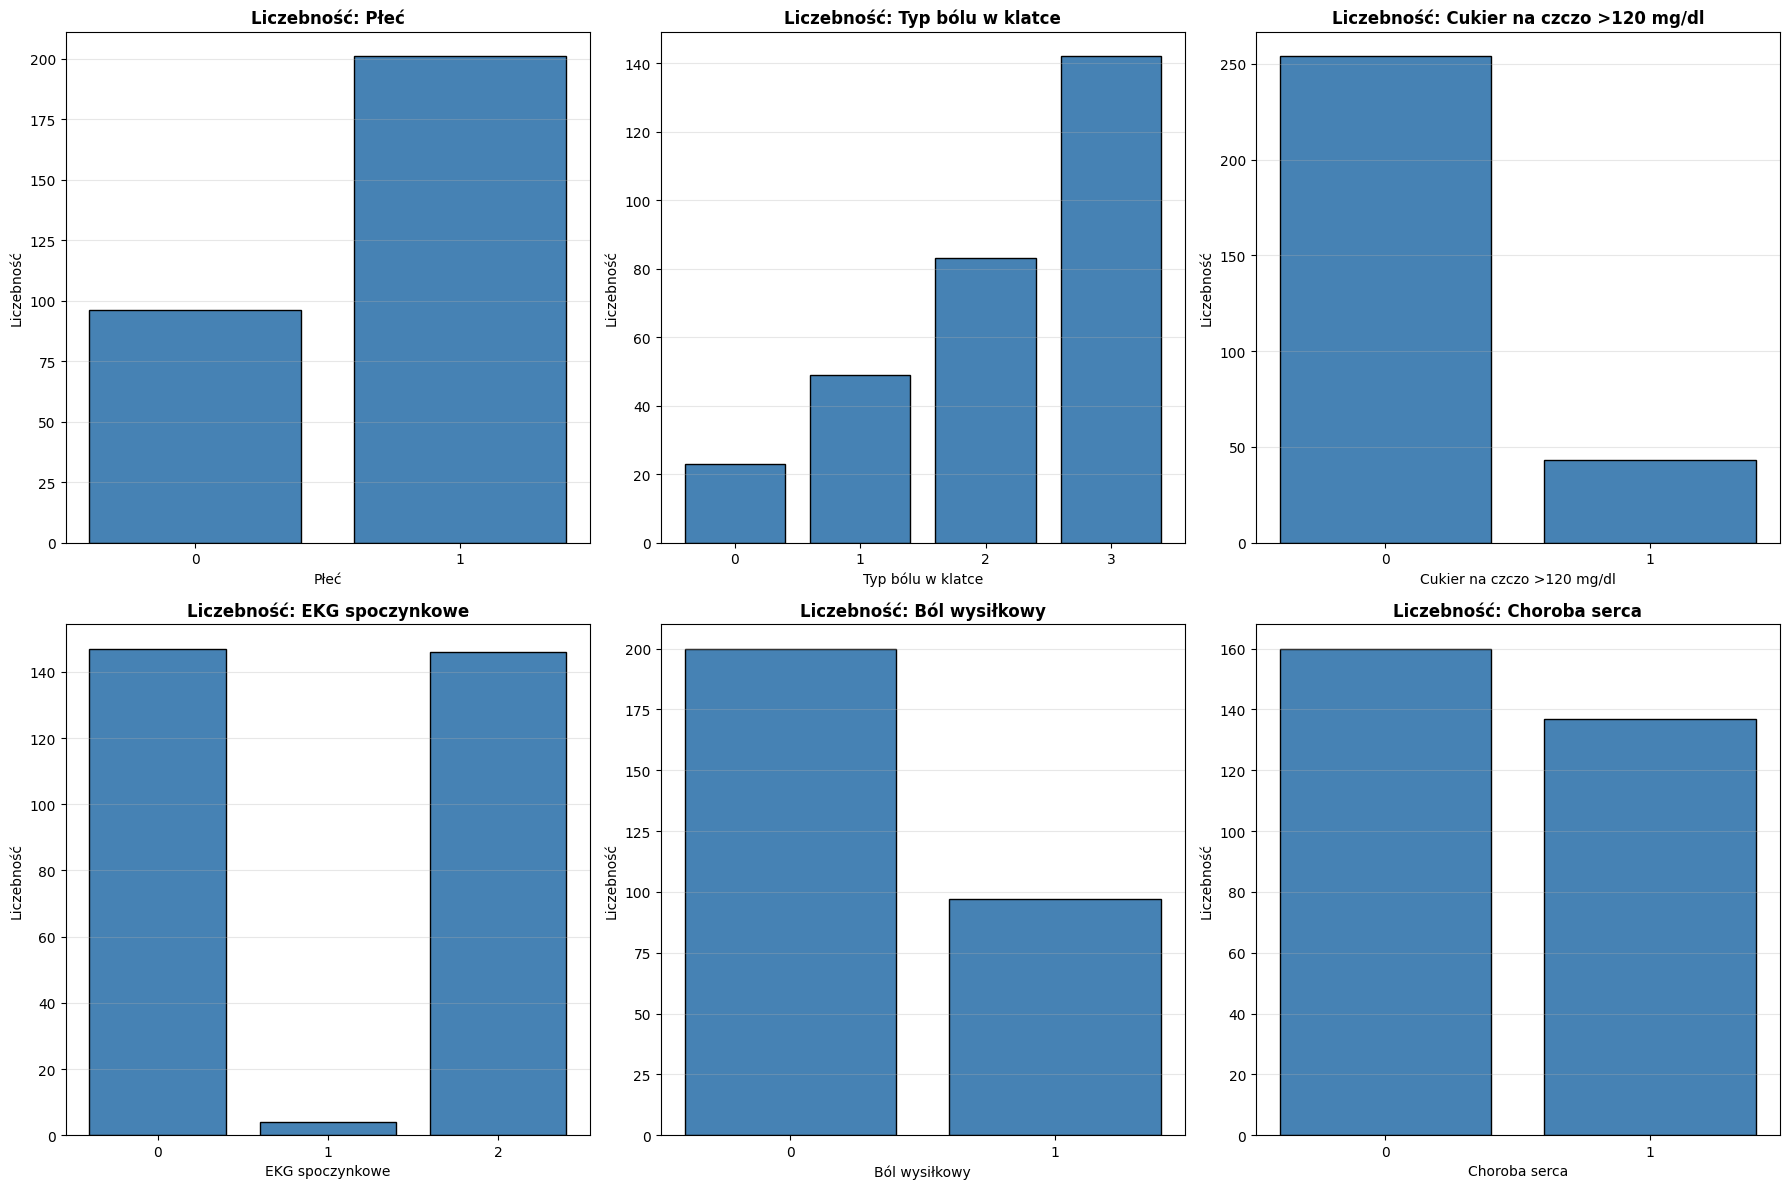

✓ Wykres zapisany: heart_output/bar_charts.png


In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'condition']
for idx, col in enumerate(categorical_cols):
    if col in df_clean.columns and idx < len(axes):
        ax = axes[idx]
        value_counts = df_clean[col].value_counts().sort_index()
        ax.bar(range(len(value_counts)), value_counts.values, color='steelblue', edgecolor='black')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index)
        ax.set_xlabel(pl(col))
        ax.set_ylabel('Liczebność')
        ax.set_title(f'Liczebność: {pl(col)}', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

for idx in range(len([c for c in categorical_cols if c in df_clean.columns]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/bar_charts.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/bar_charts.png")

### 7.3 Histogramy zmiennych


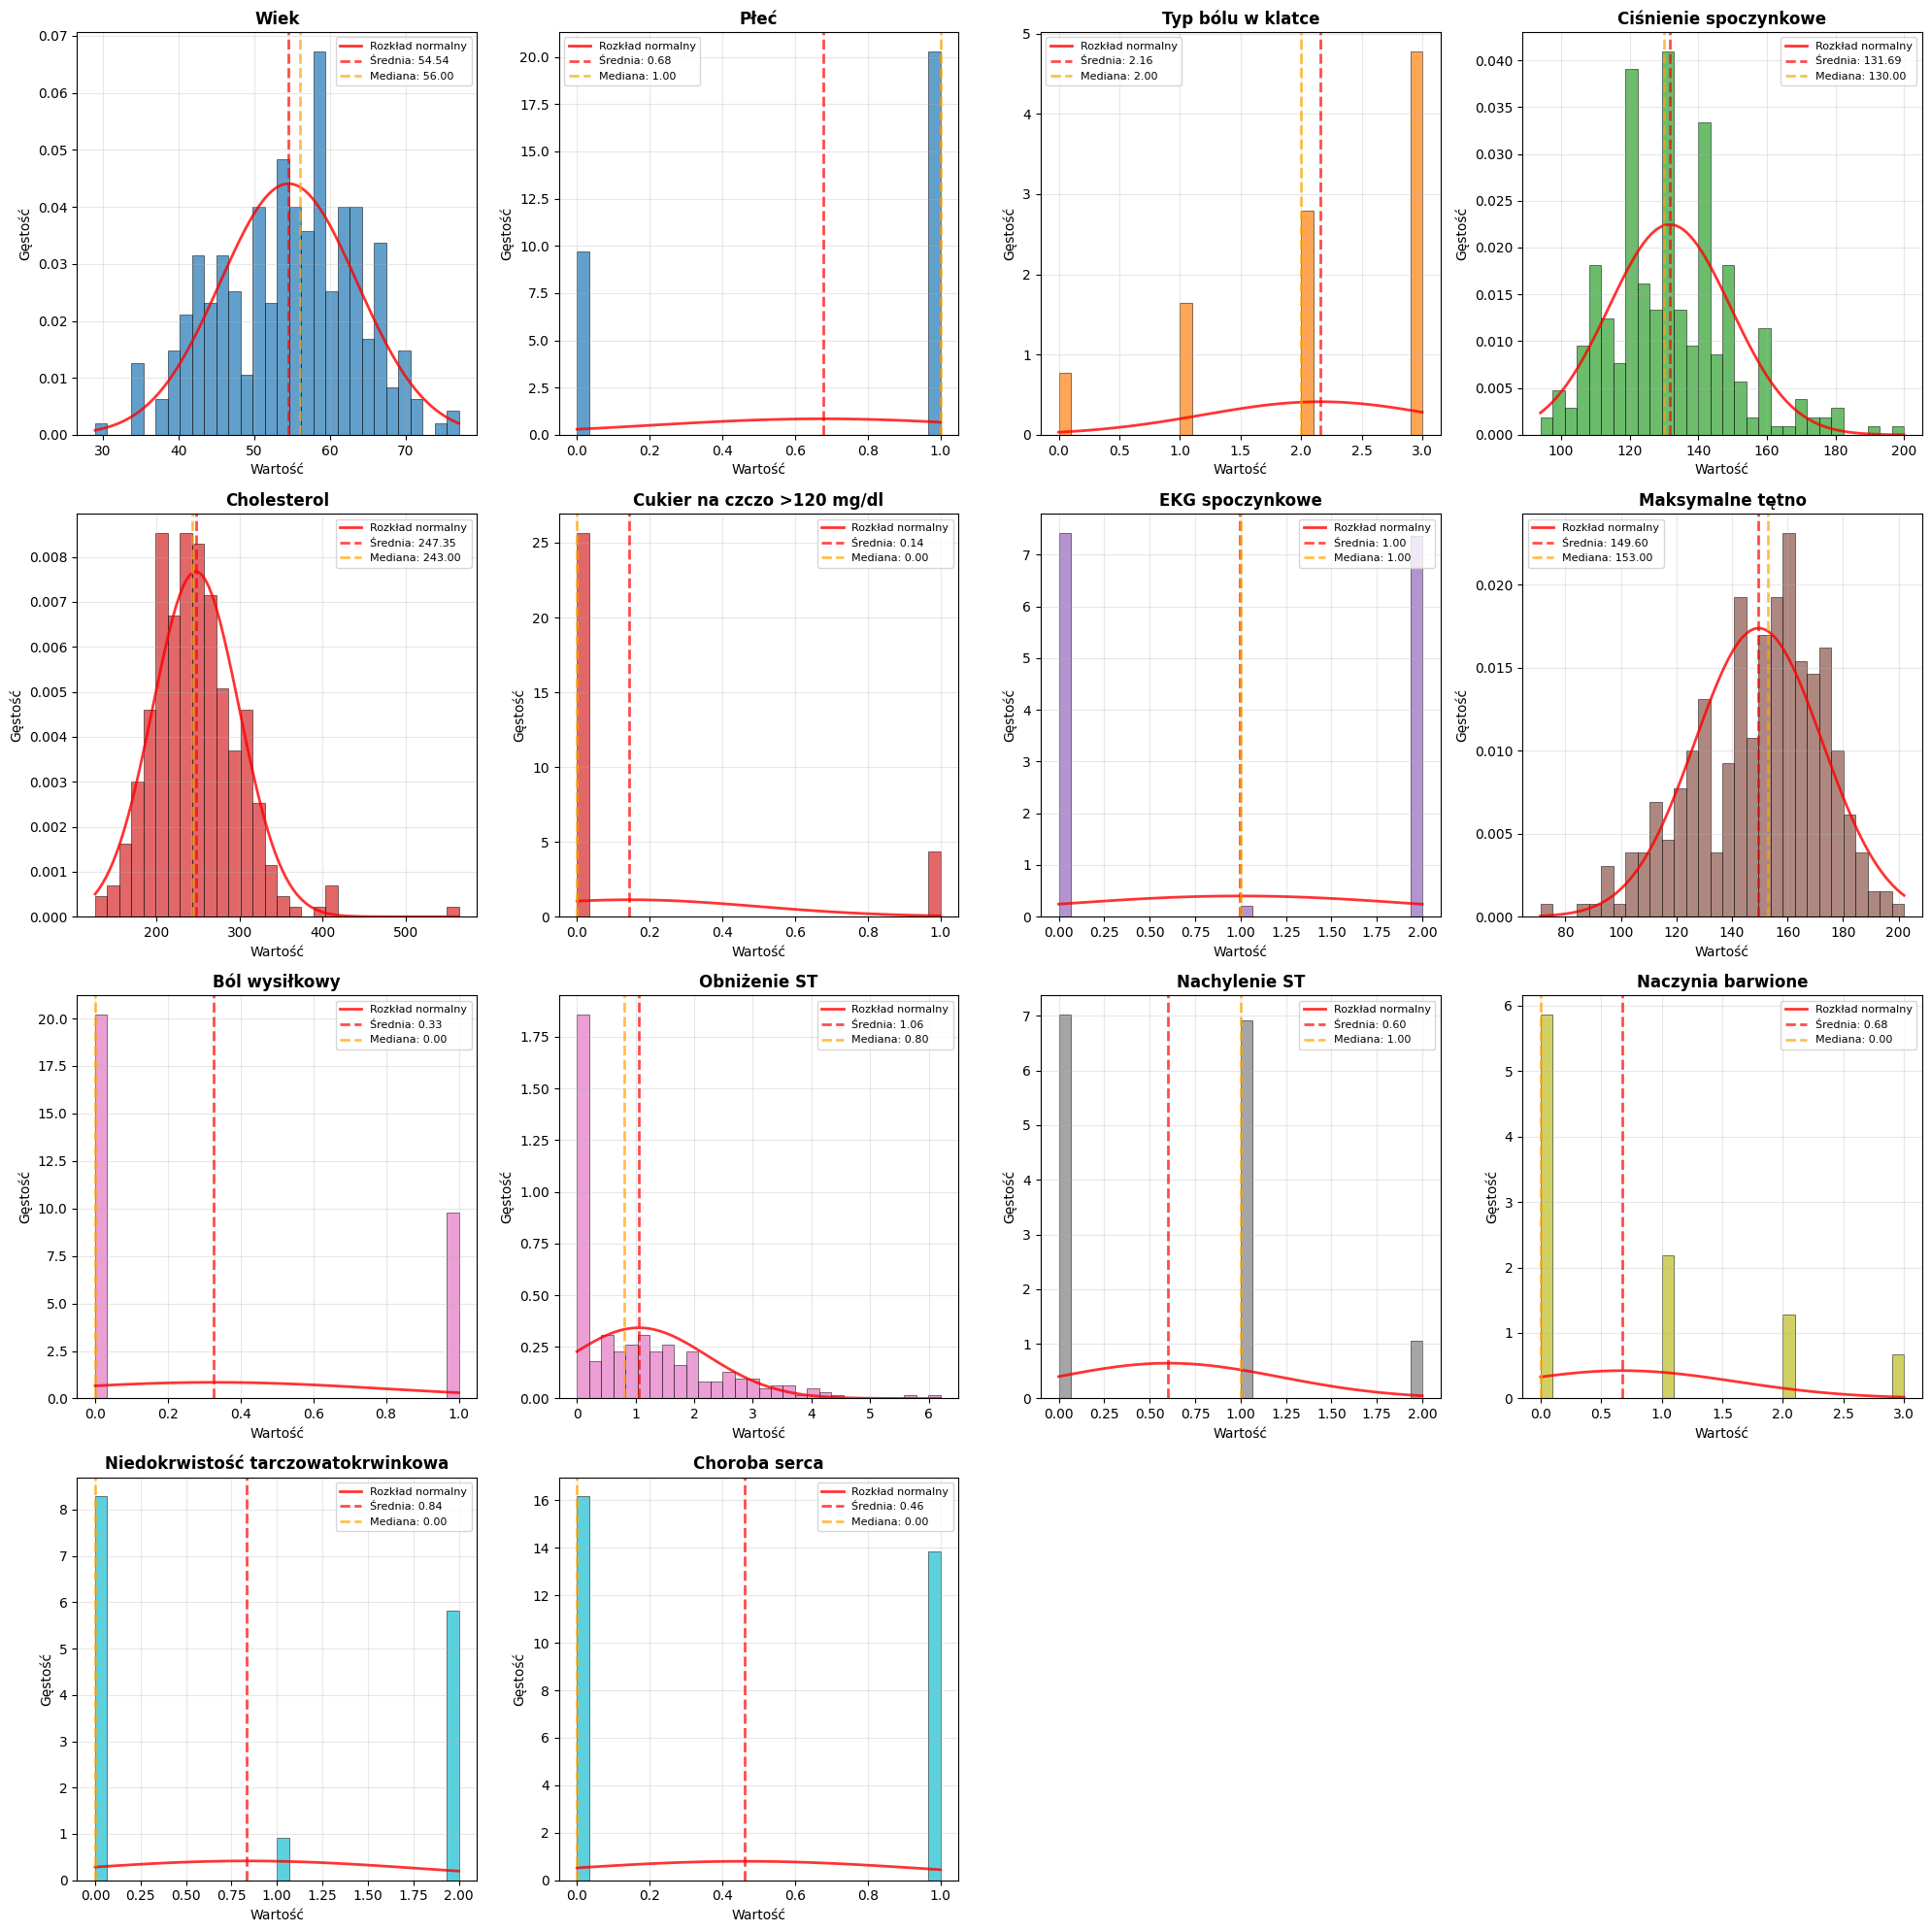

✓ Wykres zapisany: heart_output/histograms.png


In [25]:
def create_histograms(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 4
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    colors = plt.cm.tab10(np.linspace(0, 1, len(numeric_cols)))

    for i, (column, color) in enumerate(zip(numeric_cols, colors)):
        axes[i].hist(df[column], bins=30, density=True, alpha=0.7,
                    color=color, edgecolor='black', linewidth=0.5)

        x = np.linspace(df[column].min(), df[column].max(), 100)
        mean = df[column].mean()
        std = df[column].std()
        normal_curve = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

        axes[i].plot(x, normal_curve, 'r-', linewidth=2, alpha=0.8, label='Rozkład normalny')
        axes[i].axvline(mean, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Średnia: {mean:.2f}')
        axes[i].axvline(df[column].median(), color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Mediana: {df[column].median():.2f}')

        axes[i].set_title(pl(column), fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Wartość')
        axes[i].set_ylabel('Gęstość')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/histograms.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/histograms.png")

create_histograms(df_clean)

### 7.4 Wykresy pudełkowe (boxplots)


In [ ]:
def create_boxplots(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for idx, col in enumerate(numeric_cols):
        axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='navy'),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='navy'),
                   capprops=dict(color='navy'))
        axes[idx].set_ylabel(pl(col))
        axes[idx].set_title(f'Boxplot: {pl(col)}', fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/boxplots.png")

create_boxplots(df_clean)

### 7.5 Wykresy wiolinowe (violin plots)


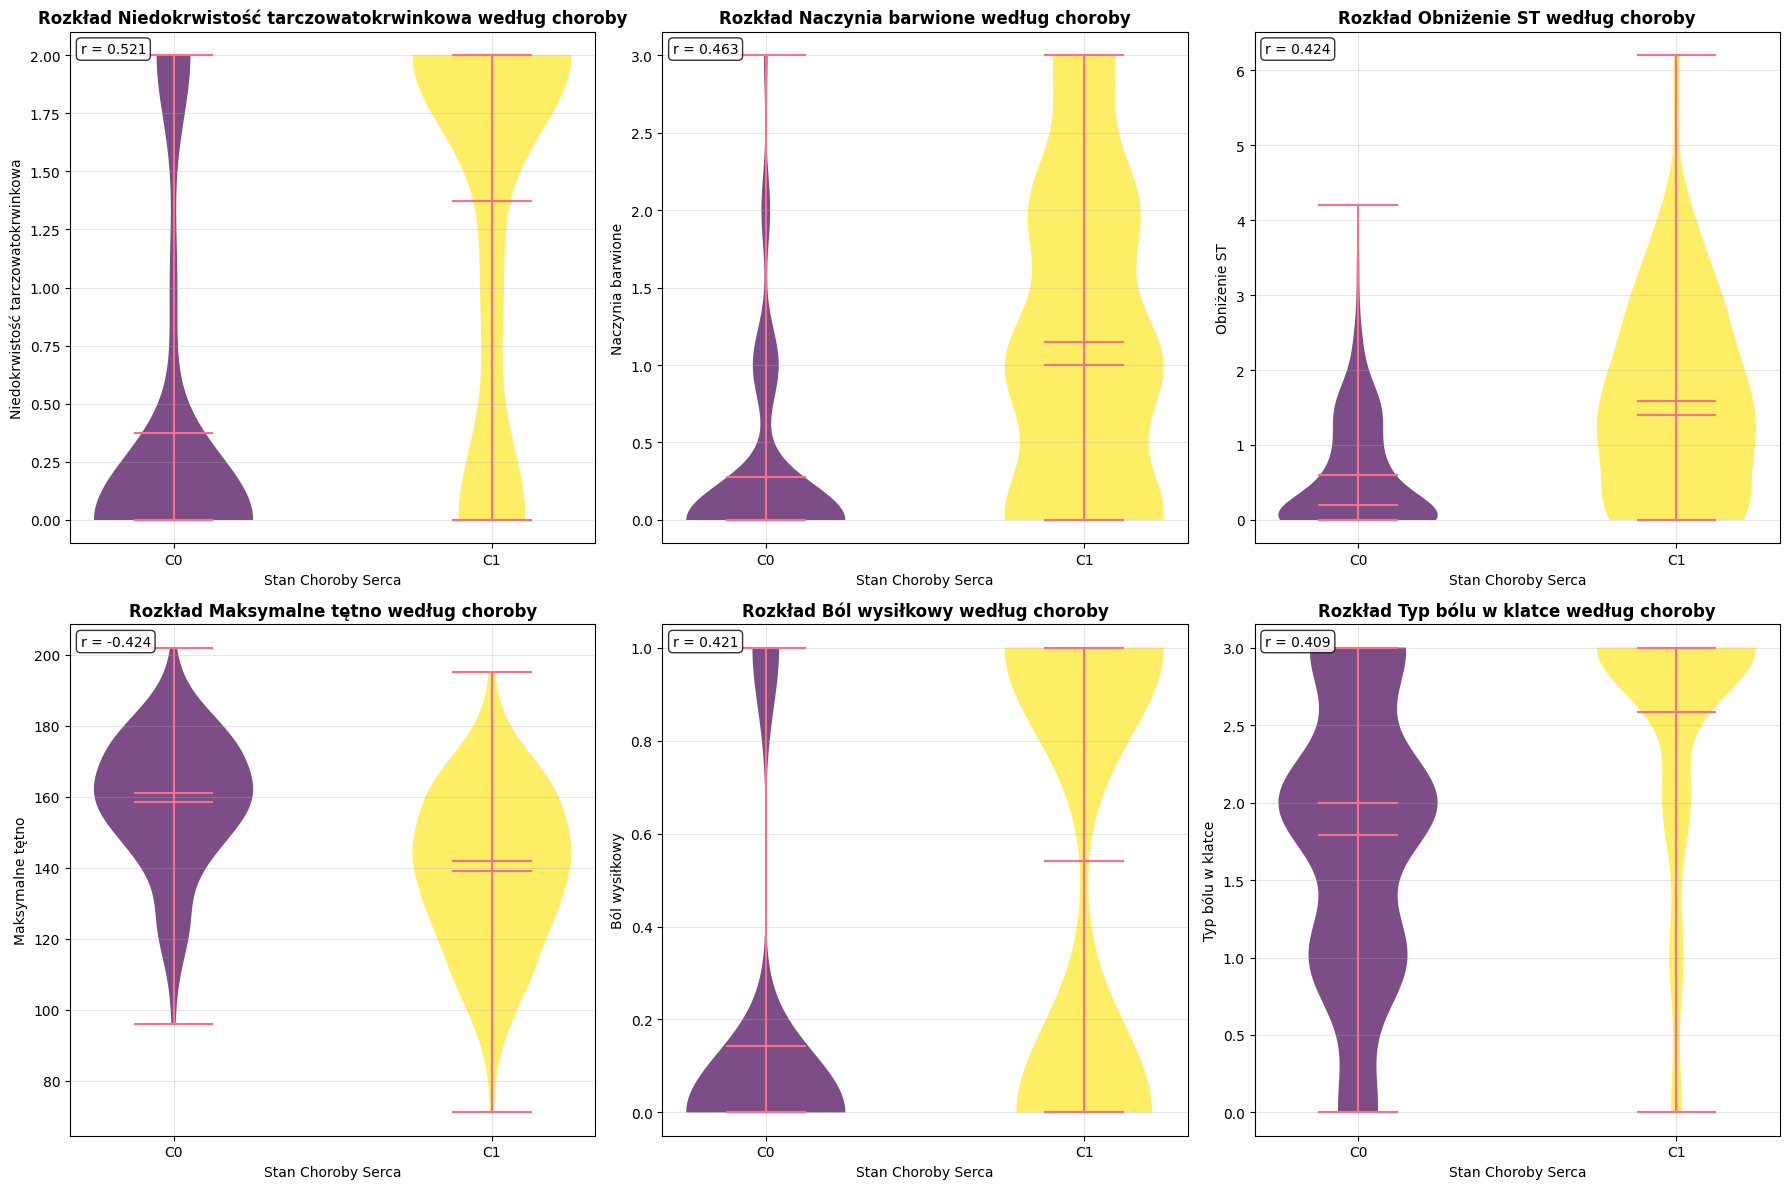

✓ Wykres zapisany: heart_output/violin_plots_1.png


In [ ]:
def create_violin_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'condition']
    condition_levels = sorted(df['condition'].unique())

    correlations = df[numeric_columns].corrwith(df['condition']).abs().sort_values(ascending=False)
    top_variables = correlations.head(6).index.tolist()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, variable in enumerate(top_variables):
        data_for_violin = []
        labels_for_violin = []

        for condition in condition_levels:
            subset_data = df[df['condition'] == condition][variable].values
            if len(subset_data) > 5:
                data_for_violin.append(subset_data)
                labels_for_violin.append(f'C{condition}')

        parts = axes[i].violinplot(data_for_violin, positions=range(1, len(data_for_violin)+1),
                                  showmeans=True, showextrema=True, showmedians=True)

        colors = plt.cm.viridis(np.linspace(0, 1, len(data_for_violin)))
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)

        axes[i].set_title(f'Rozkład {pl(variable)} według choroby', fontweight='bold')
        axes[i].set_xlabel('Stan Choroby Serca')
        axes[i].set_ylabel(pl(variable))
        axes[i].set_xticks(range(1, len(labels_for_violin)+1))
        axes[i].set_xticklabels(labels_for_violin)
        axes[i].grid(alpha=0.3)

        correlation_with_condition = df[variable].corr(df['condition'])
        axes[i].text(0.02, 0.98, f'r = {correlation_with_condition:.3f}',
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/violin_plots_1.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/violin_plots_1.png")

create_violin_plots(df_clean)

### 7.6 Wykresy rozrzutu z regresją liniową


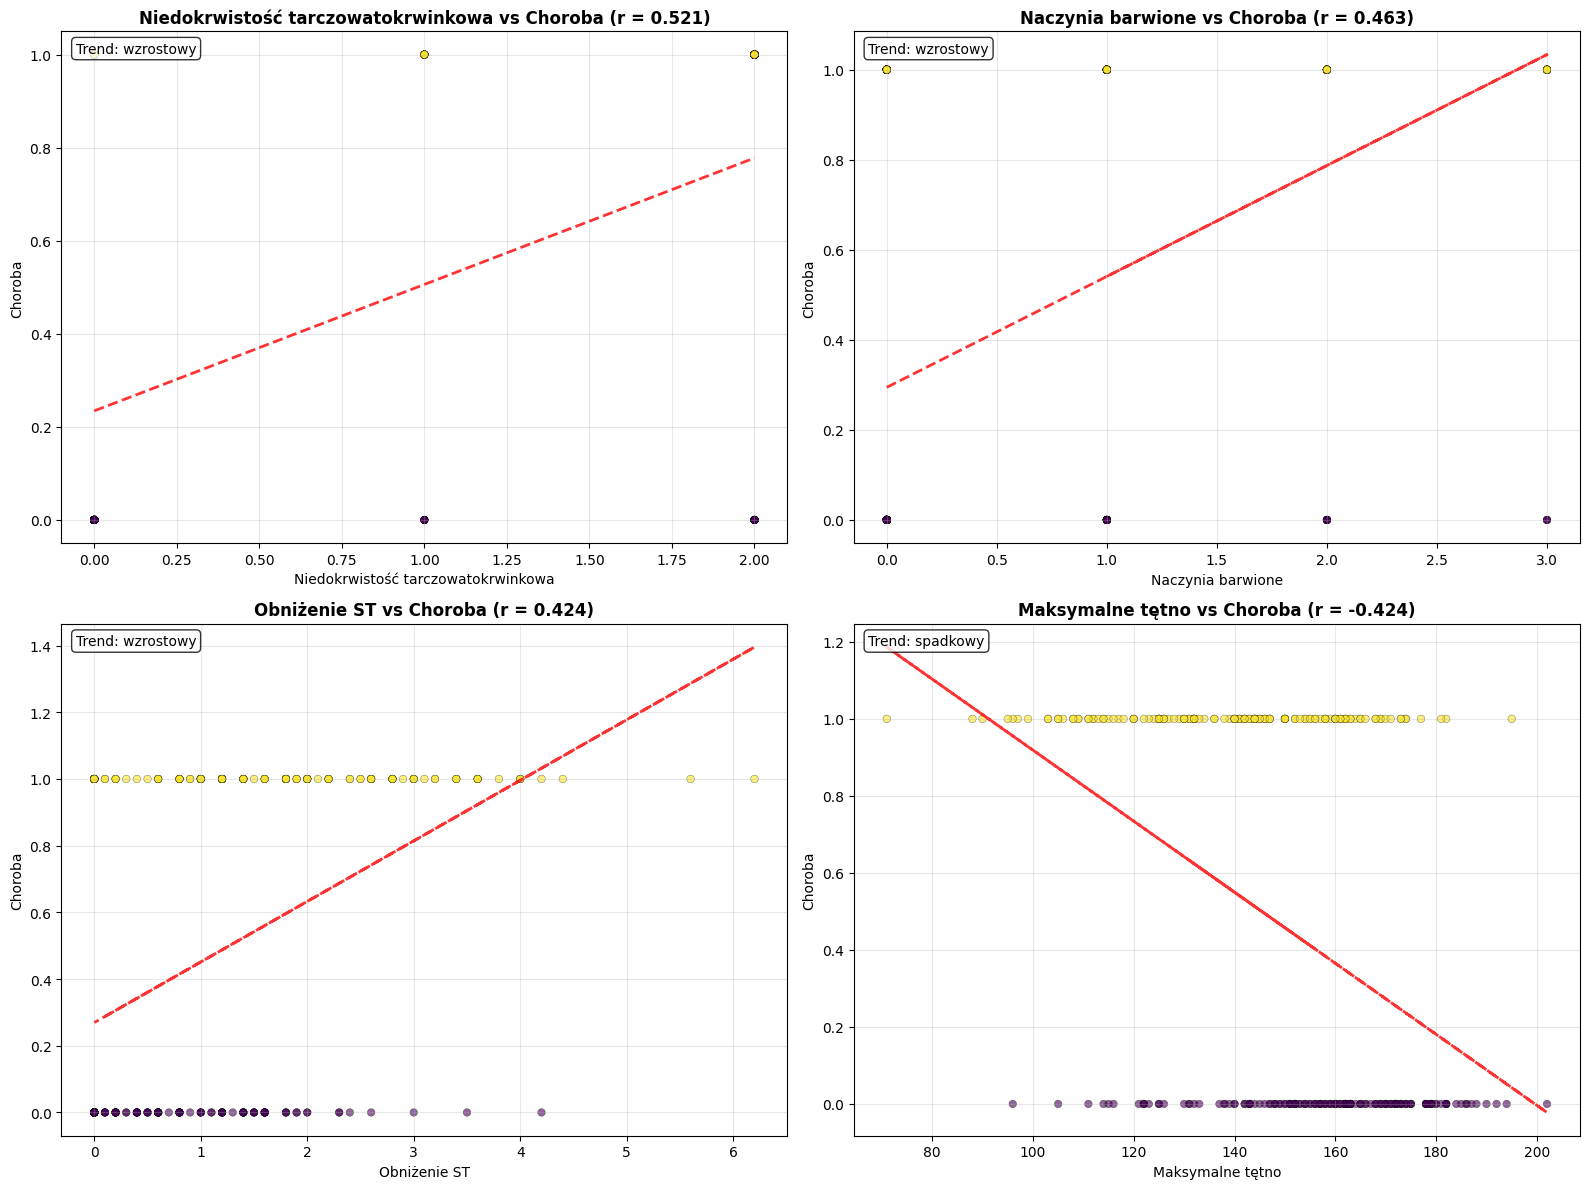

✓ Wykres zapisany: heart_output/scatter_plots.png


In [ ]:
def create_scatter_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'condition']

    correlations_with_condition = df[numeric_columns].corrwith(df['condition']).abs().sort_values(ascending=False)
    top_4_variables = correlations_with_condition.head(4).index.tolist()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, variable in enumerate(top_4_variables):
        scatter = axes[i].scatter(df[variable], df['condition'],
                                 c=df['condition'], cmap='viridis',
                                 alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

        z = np.polyfit(df[variable], df['condition'], 1)
        p = np.poly1d(z)
        axes[i].plot(df[variable], p(df[variable]), "r--", alpha=0.8, linewidth=2)

        correlation = df[variable].corr(df['condition'])
        axes[i].set_title(f'{pl(variable)} vs Choroba (r = {correlation:.3f})', fontweight='bold')
        axes[i].set_xlabel(pl(variable))
        axes[i].set_ylabel('Choroba')
        axes[i].grid(True, alpha=0.3)

        axes[i].text(0.02, 0.98, f'Trend: {"wzrostowy" if correlation > 0 else "spadkowy"}',
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/scatter_plots.png")

create_scatter_plots(df_clean)

### 7.7 Mapa ciepła korelacji


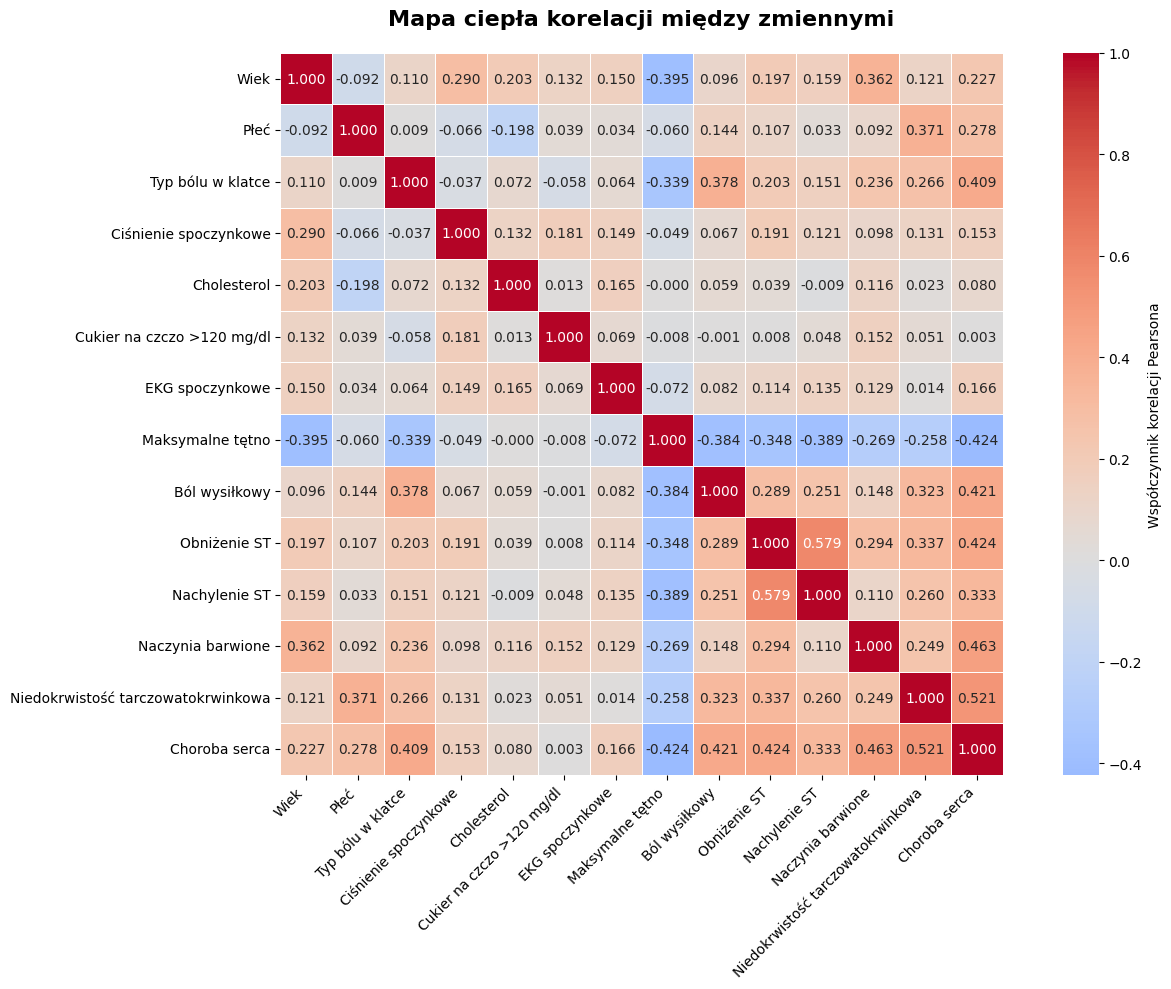

✓ Wykres zapisany: heart_output/correlation_heatmap.png


In [ ]:
def create_correlation_heatmap(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_columns].corr()

    plt.figure(figsize=(14, 10))

    heatmap = sns.heatmap(correlation_matrix,
                         annot=True,
                         cmap='coolwarm',
                         center=0,
                         square=True,
                         fmt='.3f',
                         cbar_kws={'label': 'Współczynnik korelacji Pearsona'},
                         linewidths=0.5)

    plt.title('Mapa ciepła korelacji między zmiennymi', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(ticks=np.arange(len(numeric_columns))+0.5, labels=[pl(c) for c in numeric_columns], rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(numeric_columns))+0.5, labels=[pl(c) for c in numeric_columns], rotation=0)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/correlation_heatmap.png")

create_correlation_heatmap(df_clean)

## 8. Podsumowanie analizy


In [ ]:
def generate_comprehensive_summary(df, correlation_matrix, descriptive_stats):
    print("=" * 80)
    print("KOMPLEKSOWE PODSUMOWANIE ANALIZY CHORÓB SERCA")
    print("=" * 80)

    print(f"\n1. PODSTAWOWE INFORMACJE O ZBIORZE DANYCH:")
    print(f"   • Liczba obserwacji: {len(df)}")
    print(f"   • Liczba zmiennych: {df.shape[1]}")
    print(f"   • Zakres {pl('condition')} (condition): {df['condition'].min()} - {df['condition'].max()}")
    print(f"   • Średni poziom {pl('condition')} (condition): {df['condition'].mean():.2f} ± {df['condition'].std():.2f}")

    print(f"\n2. JAKOŚĆ DANYCH:")
    missing_data = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    print(f"   • Brakujące wartości: {missing_data} (0.0%)")
    print(f"   • Duplikaty: {duplicates}")
    print(f"   • Status danych: {'Czyste' if missing_data == 0 and duplicates == 0 else 'Wymagają czyszczenia'}")

    print(f"\n3. KLUCZOWE STATYSTYKI OPISOWE:")
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in list(numeric_columns)[:3]:
        if column in df.columns:
            mean_val = df[column].mean()
            std_val = df[column].std()
            median_val = df[column].median()
            print(f"   • {pl(column)} ({column}): średnia = {mean_val:.2f}, mediana = {median_val:.2f}, σ = {std_val:.2f}")

    print(f"\n4. ANALIZA KORELACJI:")
    condition_corrs = df[numeric_columns].corrwith(df['condition']).abs().sort_values(ascending=False)

    print(f"   • Najsilniejsze predyktory {pl('condition')} (condition):")
    rank_idx = 0
    for var, corr in condition_corrs.items():
        if var != 'condition':
            rank_idx += 1
            if rank_idx <= 5:
                direction = "dodatnia" if df[var].corr(df['condition']) > 0 else "ujemna"
                strength = "bardzo silna" if corr > 0.7 else "silna" if corr > 0.5 else "umiarkowana" if corr > 0.3 else "słaba"
                print(f"     {rank_idx}. {pl(var)} ({var}): r = {df[var].corr(df['condition']):.3f} ({direction}, {strength})")

    print(f"\n   • Najsilniejsze korelacje między zmiennymi (bez {pl('condition')}):")
    strong_pairs = []
    for i, col1 in enumerate(numeric_columns):
        for j, col2 in enumerate(numeric_columns):
            if i < j and col1 != 'condition' and col2 != 'condition':
                corr = correlation_matrix.loc[col1, col2]
                if abs(corr) > 0.5:
                    strong_pairs.append((col1, col2, corr))

    strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    if strong_pairs:
        for col1, col2, corr in strong_pairs[:3]:
            print(f"     • {pl(col1)} ({col1}) ↔ {pl(col2)} ({col2}): r = {corr:.3f}")
    else:
        print(f"     • Brak silnych korelacji między zmiennymi (|r| > 0.5)")

    print(f"\n5. PRZYGOTOWANIE DO MODELOWANIA ML:")
    feature_ranking = [(col, abs(df[col].corr(df['condition'])), df[col].corr(df['condition']))
                      for col in numeric_columns if col != 'condition']
    feature_ranking.sort(key=lambda x: x[1], reverse=True)

    best_predictors = [x[0] for x in feature_ranking[:3]]
    print(f"   • Top 3 cechy dla XGBoost/Random Forest:")
    for i, (predictor, abs_corr, corr) in enumerate(feature_ranking[:3], 1):
        print(f"     {i}. {pl(predictor)} ({predictor}): r = {corr:.3f}")

    print(f"\n6. ROZKŁADY ZMIENNYCH:")
    print(f"   • Analiza normalności (test Shapiro-Wilk / KS):")
    normal_vars = []
    non_normal_vars = []

    for column in numeric_columns:
        if len(df) <= 5000:
            _, p_value = stats.shapiro(df[column].sample(min(1000, len(df))))
        else:
            _, p_value = stats.kstest(df[column], 'norm',
                                    args=(df[column].mean(), df[column].std()))

        if p_value > 0.05:
            normal_vars.append(column)
        else:
            non_normal_vars.append(column)

    print(f"     Rozkład normalny ({len(normal_vars)}): {', '.join(pl(c) for c in normal_vars) if normal_vars else 'Brak'}")
    non_norm_display = ', '.join(pl(c) for c in non_normal_vars[:3]) + ('...' if len(non_normal_vars) > 3 else '')
    print(f"     Rozkład nienormalny ({len(non_normal_vars)}): {non_norm_display if non_normal_vars else 'Brak'}")

    print(f"\n7. WARTOŚCI ODSTAJĄCE:")
    total_outliers = 0
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]
        total_outliers += len(outliers)

    outlier_percentage = (total_outliers / (len(df) * len(numeric_columns))) * 100
    print(f"   • Procent wartości odstających: {outlier_percentage:.1f}%")
    print(f"   • Status: {'Normalny' if outlier_percentage < 5 else 'Podwyższony' if outlier_percentage < 10 else 'Wysoki'} poziom wartości ekstremalnych")

    print(f"\n8. WNIOSKI I REKOMENDACJE:")
    print(f"   ✓ Zbiór danych jest kompletny i gotowy do analizy")
    print(f"   ✓ Zidentyfikowano kluczowe predyktory {pl('condition')} (condition)")
    print(f"   ✓ Dane przygotowane do modelowania XGBoost/Random Forest")
    print(f"   ✓ Kompleksowa analiza statystyczna i wizualizacja zakończona")

    print(f"\n" + "=" * 80)
    print("ANALIZA ZAKOŃCZONA POMYŚLNIE")
    print("=" * 80)

correlation_heatmap = df_clean.select_dtypes(include=[np.number]).corr()
generate_comprehensive_summary(df_clean, correlation_heatmap, descriptive_stats)

KOMPLEKSOWE PODSUMOWANIE ANALIZY CHORÓB SERCA

1. PODSTAWOWE INFORMACJE O ZBIORZE DANYCH:
   • Liczba obserwacji: 297
   • Liczba zmiennych: 14
   • Zakres Choroba serca (condition): 0 - 1
   • Średni poziom Choroba serca (condition): 0.46 ± 0.50

2. JAKOŚĆ DANYCH:
   • Brakujące wartości: 0 (0.0%)
   • Duplikaty: 0
   • Status danych: Czyste

3. KLUCZOWE STATYSTYKI OPISOWE:
   • Wiek (age): średnia = 54.54, mediana = 56.00, σ = 9.05
   • Płeć (sex): średnia = 0.68, mediana = 1.00, σ = 0.47
   • Typ bólu w klatce (cp): średnia = 2.16, mediana = 2.00, σ = 0.96

4. ANALIZA KORELACJI:
   • Najsilniejsze predyktory Choroba serca (condition):
     1. Niedokrwistość tarczowatokrwinkowa (thal): r = 0.521 (dodatnia, silna)
     2. Naczynia barwione (ca): r = 0.463 (dodatnia, umiarkowana)
     3. Obniżenie ST (oldpeak): r = 0.424 (dodatnia, umiarkowana)
     4. Maksymalne tętno (thalach): r = -0.424 (ujemna, umiarkowana)
     5. Ból wysiłkowy (exang): r = 0.421 (dodatnia, umiarkowana)

   • Naj